## Задание

1. Возьмите какую-либо свою DL модель или же модель из model zoo.  Например, [ONNX Model Zoo](https://github.com/onnx/models) или [TF Model Zoo](https://github.com/tensorflow/models).
    - Импортируйте её в TVM.
    - Запустите её с помощью TVM.
    - Настройте модель с помощью всех алгоритмов настройки (AutoTVM, Auto-Scheduler и Meta-Scheduler)

Будем работать на примере ONNX моделей. Гайд от TVM: [resnet](https://tvm.apache.org/docs/tutorial/autotvm_relay_x86.html#sphx-glr-tutorial-autotvm-relay-x86-py)

In [1]:
import onnx
from tvm.contrib.download import download_testdata
from PIL import Image
import numpy as np
import tvm.relay as relay
import tvm
from tvm.contrib import graph_executor

In [2]:
model_url = (
    "https://github.com/onnx/models/raw/main/"
    "vision/classification/resnet/model/"
    "resnet50-v2-7.onnx"
)

model_path = download_testdata(model_url, "resnet50-v2-7.onnx", module="onnx")
onnx_model = onnx.load(model_path)

# Seed numpy's RNG to get consistent results
np.random.seed(0)

In [3]:
img_url = "https://s3.amazonaws.com/model-server/inputs/kitten.jpg"
img_path = download_testdata(img_url, "imagenet_cat.png", module="data")

# Resize it to 224x224
resized_image = Image.open(img_path).resize((224, 224))
img_data = np.asarray(resized_image).astype("float32")

# Our input image is in HWC layout while ONNX expects CHW input, so convert the array
img_data = np.transpose(img_data, (2, 0, 1))

# Normalize according to the ImageNet input specification
imagenet_mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
imagenet_stddev = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
norm_img_data = (img_data / 255 - imagenet_mean) / imagenet_stddev

# Add the batch dimension, as we are expecting 4-dimensional input: NCHW.
img_data = np.expand_dims(norm_img_data, axis=0)

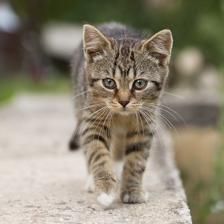

In [37]:
resized_image

In [4]:
target = "llvm"

# The input name may vary across model types. You can use a tool
# like Netron to check input names
input_name = "data"
shape_dict = {input_name: img_data.shape}

mod, params = relay.frontend.from_onnx(onnx_model, shape_dict)

with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, params=params)

dev = tvm.device(str(target), 0)
module = graph_executor.GraphModule(lib["default"](dev))

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


In [5]:
dtype = "float32"
module.set_input(input_name, img_data)
module.run()
output_shape = (1, 1000)
tvm_output = module.get_output(0, tvm.nd.empty(output_shape)).numpy()

In [6]:
from scipy.special import softmax

# Download a list of labels
labels_url = "https://s3.amazonaws.com/onnx-model-zoo/synset.txt"
labels_path = download_testdata(labels_url, "synset.txt", module="data")

with open(labels_path, "r") as f:
    labels = [l.rstrip() for l in f]

# Open the output and read the output tensor
scores = softmax(tvm_output)
scores = np.squeeze(scores)
ranks = np.argsort(scores)[::-1]
for rank in ranks[0:5]:
    print("class='%s' with probability=%f" % (labels[rank], scores[rank]))

class='n02123045 tabby, tabby cat' with probability=0.621103
class='n02123159 tiger cat' with probability=0.356379
class='n02124075 Egyptian cat' with probability=0.019712
class='n02129604 tiger, Panthera tigris' with probability=0.001215
class='n04040759 radiator' with probability=0.000262


In [7]:
import tvm.auto_scheduler as auto_scheduler
from tvm.autotvm.tuner import XGBTuner
from tvm import autotvm

In [8]:
model_name = "my_model"

import multiprocessing
import os
# Set number of threads used for tuning based on the number of
# physical CPU cores on your machine.
num_threads = multiprocessing.cpu_count()
print("Num threads: ", int(num_threads/2))
os.environ["TVM_NUM_THREADS"] = str(int(num_threads/2))

Num threads:  6


In [9]:
def evaluate_performance(lib, img_data, dtype="float32"):
    # upload parameters to device
    dev = tvm.cpu()
    # data_tvm = tvm.nd.array((np.random.uniform(size=data_shape)).astype(dtype))
    data_tvm = img_data
    module = graph_executor.GraphModule(lib["default"](dev))
    module.set_input(input_name, data_tvm)

    # evaluate
    print("Evaluate inference time cost...")
    print(module.benchmark(dev, number=100, repeat=3))

In [10]:
number = 10
repeat = 1
min_repeat_ms = 0  # since we're tuning on a CPU, can be set to 0
timeout = 10  # in seconds

# create a TVM runner
runner = autotvm.LocalRunner(
    number=number,
    repeat=repeat,
    timeout=timeout,
    min_repeat_ms=min_repeat_ms,
    enable_cpu_cache_flush=True,
)

tuning_option = {
    "tuner": "xgb",
    "trials": 20,
    "early_stopping": 100,
    "measure_option": autotvm.measure_option(
        builder=autotvm.LocalBuilder(build_func="default"), runner=runner
    ),
    "tuning_records": "resnet-50-v2-autotuning.json",
}

In [13]:
# begin by extracting the tasks from the onnx model
tasks = autotvm.task.extract_from_program(mod["main"], target=target, params=params)

# Tune the extracted tasks sequentially.
for i, task in enumerate(tasks):
    prefix = "[Task %2d/%2d] " % (i + 1, len(tasks))
    tuner_obj = XGBTuner(task, loss_type="rank")
    tuner_obj.tune(
        n_trial=min(tuning_option["trials"], len(task.config_space)),
        early_stopping=tuning_option["early_stopping"],
        measure_option=tuning_option["measure_option"],
        callbacks=[
            autotvm.callback.progress_bar(tuning_option["trials"], prefix=prefix),
            autotvm.callback.log_to_file(tuning_option["tuning_records"]),
        ],
    )

[Task  1/25]  Current/Best:   28.54/  48.99 GFLOPS | Progress: (20/20) | 38.55 s Done.
[Task  2/25]  Current/Best:    7.83/  31.49 GFLOPS | Progress: (20/20) | 27.96 s Done.
[Task  3/25]  Current/Best:   39.03/  44.54 GFLOPS | Progress: (20/20) | 29.13 s Done.
[Task  4/25]  Current/Best:   24.59/  26.94 GFLOPS | Progress: (20/20) | 38.37 s Done.
[Task  5/25]  Current/Best:   29.60/  47.03 GFLOPS | Progress: (20/20) | 30.37 s Done.
[Task  6/25]  Current/Best:   22.24/  50.46 GFLOPS | Progress: (20/20) | 30.30 s Done.
[Task  7/25]  Current/Best:   28.22/  44.11 GFLOPS | Progress: (20/20) | 31.92 s Done.
[Task  8/25]  Current/Best:   19.70/  35.36 GFLOPS | Progress: (20/20) | 40.07 s Done.
[Task 10/25]  Current/Best:    6.88/  47.86 GFLOPS | Progress: (20/20) | 30.34 s Done.
[Task 11/25]  Current/Best:   16.17/  49.53 GFLOPS | Progress: (20/20) | 30.76 s Done.
[Task 13/25]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/20) | 0.00 s s Done.
 Done.
[Task 13/25]  Current/Best:   26.16/

In [11]:
def evaluate(module, img_data, tuning_option, target="llvm"):
    # compile kernels in default mode
    print("Evaluation of the network compiled in 'default' mode without auto tune:")
    with tvm.transform.PassContext(opt_level=3):
        print("Compile...")
        lib = relay.build(module, target=target, params=params)
        evaluate_performance(lib, img_data)

    # compile kernels in kernel tuned only mode
    print("\nEvaluation of the network been tuned on kernel level:")
    with autotvm.apply_history_best(tuning_option["tuning_records"]):
        print("Compile...")
        with tvm.transform.PassContext(opt_level=3):
            lib = relay.build(module, target=target, params=params)
        evaluate_performance(lib, img_data)

In [17]:
evaluate(mod, img_data, tuning_option, target)

Evaluation of the network compiled in 'default' mode without auto tune:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  122.0461     122.5908     122.8522     120.6953      0.9611   
               

Evaluation of the network been tuned on kernel level:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  108.8156     108.3085     110.6327     107.5056      1.3260   
               


In [12]:
from tvm import auto_scheduler

In [13]:
log_file = "%s.auto-scheduler.log" % model_name

In [20]:
# extract workloads from relay program
def extract_tasks(mod, target, params):
    print("Extract tasks...")
    tasks, task_weights = auto_scheduler.extract_tasks(mod, params, target)
    assert(len(tasks) > 0)

    for idx, task in enumerate(tasks):
        print("Task: %d, desc: %s" % (idx, task.desc))
    return tasks, task_weights

In [21]:
# begin by extracting the tasks from the onnx model
tasks, task_weights = extract_tasks(mod["main"], target=target, params=params)

Mod:
fn (%data: Tensor[(1, 3, 224, 224), float32] /* ty=Tensor[(1, 3, 224, 224), float32] */) -> Tensor[(1, 1000), float32] {
  %0 = nn.batch_norm(%data, meta[relay.Constant][0] /* ty=Tensor[(3), float32] */, meta[relay.Constant][1] /* ty=Tensor[(3), float32] */, meta[relay.Constant][2] /* ty=Tensor[(3), float32] */, meta[relay.Constant][3] /* ty=Tensor[(3), float32] */) /* ty=(Tensor[(1, 3, 224, 224), float32], Tensor[(3), float32], Tensor[(3), float32]) */;
  %1 = %0.0 /* ty=Tensor[(1, 3, 224, 224), float32] */;
  %2 = nn.conv2d(%1, meta[relay.Constant][4] /* ty=Tensor[(64, 3, 7, 7), float32] */, strides=[2, 2], padding=[3, 3, 3, 3], channels=64, kernel_size=[7, 7]) /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %3 = nn.batch_norm(%2, meta[relay.Constant][5] /* ty=Tensor[(64), float32] */, meta[relay.Constant][6] /* ty=Tensor[(64), float32] */, meta[relay.Constant][7] /* ty=Tensor[(64), float32] */, meta[relay.Constant][8] /* ty=Tensor[(64), float32] */) /* ty=(Tensor[(1, 64, 112, 11

In [22]:
def run_tuning(tasks, task_weights, log_file, n_trials):
    print("Begin tuning...")
    tuner = auto_scheduler.TaskScheduler(tasks, task_weights)
    tune_option = auto_scheduler.TuningOptions(
        num_measure_trials=n_trials,  # change this to 20000 to achieve the best performance
        runner=auto_scheduler.LocalRunner(repeat=10, enable_cpu_cache_flush=True),
        measure_callbacks=[auto_scheduler.RecordToFile(log_file)],
    )

    tuner.tune(tune_option)

In [23]:
# We have 31 tasks: 31*64=1984
run_tuning(tasks, task_weights, log_file,  1984)

Begin tuning...
|  ID  |                       Task Description                        | Latency (ms) | Speed (GFLOPS) | Trials |
-----------------------------------------------------------------------------------------------------------------
|    0 |           vm_mod_fused_nn_contrib_conv2d_NCHWc_add_nn_relu_13 |            - |              - |      0 |
----------------------------------------------------------------------
------------------------------  [ Task Scheduler ]
----------------------------------------------------------------------
|    1 |           vm_mod_fused_nn_contrib_conv2d_NCHWc_add_nn_relu_14 |            - |              - |      0 |
|    2 |            vm_mod_fused_nn_contrib_conv2d_NCHWc_add_nn_relu_4 |            - |              - |      0 |
|    3 |              vm_mod_fused_nn_contrib_conv2d_NCHWc_add_nn_relu |            - |              - |      0 |
|    4 |        vm_mod_fused_nn_contrib_conv2d_NCHWc_add_add_nn_relu_2 |            - |              - |   

In [24]:
def evaluate(module, img_data, log_file, target="llvm"):
    # compile kernels in default mode
    print("Evaluation of the network compiled in 'default' mode without auto tune:")
    with tvm.transform.PassContext(opt_level=3):
        print("Compile...")
        lib = relay.build(module, target=target, params=params)
        evaluate_performance(lib, img_data)

    # compile kernels in kernel tuned only mode
    print("\nEvaluation of the network been tuned on kernel level:")
    with auto_scheduler.ApplyHistoryBest(log_file):
        print("Compile...")
        with tvm.transform.PassContext(opt_level=3, config={"relay.backend.use_auto_scheduler": True}):
            lib = relay.build(module, target=target, params=params)
        evaluate_performance(lib, img_data)

In [25]:
evaluate(mod, img_data, log_file, target)

Evaluation of the network compiled in 'default' mode without auto tune:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  121.3185     121.7978     122.2736     119.8841      1.0327   
               

Evaluation of the network been tuned on kernel level:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  116.7790     116.3745     117.9221     116.0403      0.8197   
               


In [26]:
from tvm import meta_schedule as ms

In [27]:
strategy_name = "evolutionary"
work_dir = "{}_meta-scheduler_{}".format(model_name, strategy_name)
target = tvm.target.Target("llvm -mcpu=core-avx2 -num-cores {}".format(int(num_threads/2)))

In [28]:
# extract workloads from relay program
def extract_tasks(mod, target, params, strategy):
    print("Extract tasks...")
    extracted_tasks = ms.relay_integration.extract_tasks(
        mod, target, params
    )
    assert(len(extracted_tasks) > 0)
    
    tasks, task_weights = ms.relay_integration.extracted_tasks_to_tune_contexts(
        extracted_tasks, work_dir, strategy=strategy
    )

    for idx, task in enumerate(tasks):
        print("Task: %d, desc: %s" % (idx, task.task_name))

    return tasks, task_weights

In [29]:
tasks, task_weights = extract_tasks(mod, target, params, strategy_name)

Extract tasks...
2023-02-16 14:15:58 [INFO] Logging directory: my_model_meta-scheduler_evolutionary/logs
Task: 0, desc: fused_layout_transform
Task: 1, desc: fused_nn_contrib_conv2d_NCHWc
Task: 2, desc: fused_layout_transform_1
Task: 3, desc: fused_nn_contrib_conv2d_NCHWc_1
Task: 4, desc: fused_layout_transform_2
Task: 5, desc: fused_nn_contrib_conv2d_NCHWc_2
Task: 6, desc: fused_layout_transform_3
Task: 7, desc: fused_nn_contrib_conv2d_NCHWc_3
Task: 8, desc: fused_add_layout_transform
Task: 9, desc: fused_nn_contrib_conv2d_NCHWc_add_nn_relu
Task: 10, desc: fused_nn_max_pool2d_multiply_add_nn_relu
Task: 11, desc: fused_layout_transform_4
Task: 12, desc: fused_nn_contrib_conv2d_NCHWc_add_nn_relu_1
Task: 13, desc: fused_layout_transform_5
Task: 14, desc: fused_nn_contrib_conv2d_NCHWc_add
Task: 15, desc: fused_add_nn_relu_layout_transform
Task: 16, desc: fused_nn_contrib_conv2d_NCHWc_add_nn_relu_2
Task: 17, desc: fused_layout_transform_6
Task: 18, desc: fused_nn_contrib_conv2d_NCHWc_add_n

In [30]:
import os

def run_tuning(tasks, task_weights, work_dir, n_trials):
    if not os.path.exists(work_dir):
        os.mkdir(work_dir)
    print("Begin tuning...")    
    evaluator_config = ms.runner.config.EvaluatorConfig(number=1, repeat=10, enable_cpu_cache_flush=True);
    database = ms.tune.tune_tasks(
        tasks=tasks,
        task_weights=task_weights,
        work_dir=work_dir,
        max_trials_global=n_trials,
        num_trials_per_iter=64,
        max_trials_per_task=256,
        builder=ms.builder.LocalBuilder(),
        runner=ms.runner.LocalRunner(evaluator_config=evaluator_config),
    )

In [33]:
# We have 57 tasks: 57*64=3648
run_tuning(tasks, task_weights, work_dir, 3648)

2023-02-16 16:41:25 [INFO] [task_scheduler.cc:258] Task #56 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,fused_layout_transform,1,1,0.0000,49.6607,49.6607,2,Y
1,fused_nn_contrib_conv2d_NCHWc,205520896,1,169.7673,1210.6037,1210.6037,128,Y
2,fused_layout_transform_1,1,1,0.0000,94.8620,94.8620,2,Y
3,fused_nn_contrib_conv2d_NCHWc_1,205520896,1,241.9677,849.3731,849.3731,127,Y
4,fused_layout_transform_2,1,1,0.0000,282.0583,282.0583,2,Y
5,fused_nn_contrib_conv2d_NCHWc_2,205520896,1,251.1362,818.3643,818.3643,128,Y
6,fused_layout_transform_3,1,1,0.0001,14.8950,14.8950,2,Y
7,fused_nn_contrib_conv2d_NCHWc_3,102760448,1,163.9709,626.6994,626.6994,64,Y
8,fused_add_layout_transform,150528,1,8.5724,17.5597,17.5597,1,Y
9,fused_nn_contrib_conv2d_NCHWc_add_nn_relu,237633536,1,249.1890,953.6275,953.6275,128,Y



Total trials: 3695
Total latency (us): 35472.8

2023-02-16 16:41:25 [DEBUG] [task_scheduler.cc:316] 
 ID |                                                   Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------------------------------------------------
  0 |                                 fused_layout_transform |         1 |      1 |         0.0000 |      49.6607 |               49.6607 |      2 |    Y 
  1 |                          fused_nn_contrib_conv2d_NCHWc | 205520896 |      1 |       169.7673 |    1210.6037 |             1210.6037 |    128 |    Y 
  2 |                               fused_layout_transform_1 |         1 |      1 |         0.0000 |      94.8620 |               94.8620 |      2 |    Y 
  3 |                        fused_nn_contrib_conv2d_NCHWc_1 | 205520896 |      1 |       241.9677 |     849.3731 |        

In [34]:
def evaluate(module, img_data, work_dir, target="llvm"):
    # compile kernels in default mode
    print("Evaluation of the network compiled in 'default' mode without auto tune:")
    with tvm.transform.PassContext(opt_level=3):
        print("Compile...")
        lib = relay.build(module, target=target, params=params)
        evaluate_performance(lib, img_data)

    # compile kernels in kernel tuned only mode
    print("\nEvaluation of the network been tuned on kernel level:")
    print("Compile...")
    database = ms.database.JSONDatabase(f"{work_dir}/database_workload.json",
                                        f"{work_dir}/database_tuning_record.json",
                                        allow_missing=False)
    with tvm.transform.PassContext(opt_level=3):
        lib = ms.relay_integration.compile_relay(database, module, target, params)
        evaluate_performance(lib, img_data)

In [35]:
evaluate(mod, img_data, work_dir, target)

Evaluation of the network compiled in 'default' mode without auto tune:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  72.1558      71.6420      73.8420      70.9833       1.2223   
               

Evaluation of the network been tuned on kernel level:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  41.6419      41.7569      42.1532      41.0156       0.4715   
               
